# Demo

In [4]:
# imports
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import DistanceMetric
import tifffile as tif
import pacmap
from matplotlib.colors import ListedColormap
from distinctipy import distinctipy
from matplotlib import gridspec

### Get the paths to the directory containing the preprocessed data

In [5]:
spectrum_folder = '/Volumes/Microscopy3/EDX_data/Identify/main_mosaic_6by5/Spectrum2D_extendedGauss1_3_5/'
# or 'path/to/preprocessedData'

file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]

### Load data from a tile and load "labels"

In [6]:
# choose a tile 
tile_idx = 0
spectrum_2D = np.load(files[tile_idx])['spectrum_2D']

# Check the content of the supplementary file (npz extension)
supp_file_path = '/Users/aj/Desktop/PACMAP_RESULTS/Identify2/pacpam_instance/pacmap_panc_euc_20percent_SavedTree20240209-105636.npz'
# or '/path/to/PacMAPinstance'
for k in np.load(supp_file_path, mmap_mode='r').files:
    print(k)

local_maxi
description
abundance_maps
end_members
colors
overlap_ratio


## Load the abundance maps and get "labels" from them for the chosen tile

In [7]:
abundance_maps = np.load(supp_file_path)['abundance_maps']
abundance_maps = abundance_maps / np.max(abundance_maps) # Scale to have max coefficient = 1
colors = np.load(supp_file_path)['colors']
colors[0] = [0,0,0]   # changing one of the colors to black
print("Shape of abundance maps: ", abundance_maps.shape)

Shape of abundance maps:  (12, 1024, 1024, 30)


### get labels for the selected tile -  and display
- Getting every other pixel in x,y to reduce the size and make it comparable to autoencoder results
- This can act as a kind of groundtruth or sanity check to judge the separability of different feature representations of the data later

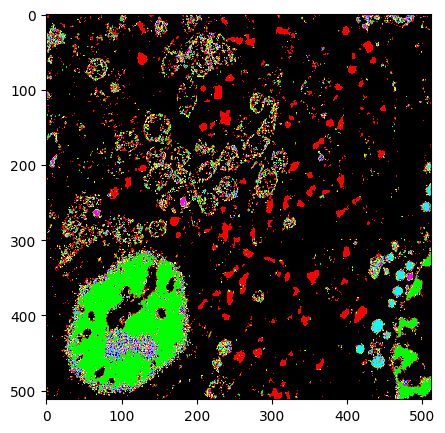

In [8]:
# comment these lines if not subsampling
spectrum_2D = spectrum_2D.reshape((1024,1024,1000))
spectrum_2D = spectrum_2D[::2,::2,:].reshape((512**2,1000))

labels = np.argmax(abundance_maps[:,::2,::2,tile_idx],axis=0)
labelColorMap = ListedColormap(colors)
f,ax = plt.subplots(figsize=(5,5))
ax.imshow(labels,cmap=labelColorMap)
plt.show()

### PaCMAP projection for different 

In [9]:
# get a subsample and account for overlaps
subsample_size = int(0.20*512**2)
overlap_mask = overlap_corr(tile_idx=tile_idx,xy_dim=512,rows=6,cols=5,overlap_ratio=0.2).ravel()
non_overlap_indices = np.asarray([i for i in range(512**2)])[~overlap_mask]
np.random.seed(0); sample = np.random.choice(non_overlap_indices, subsample_size)


# define the slices (to slice from the pre-preprocessed data)
array_length = 1000
slice_size = 250
slices = [slice(i, i + slice_size) for i in range(0, array_length, slice_size)]
#slices.append(slice(0,1000))
print(slices)

[slice(0, 250, None), slice(250, 500, None), slice(500, 750, None), slice(750, 1000, None)]


Duration for training PaCMAP is: 0:00:22.270645
Duration for training PaCMAP is: 0:00:22.047320
Duration for training PaCMAP is: 0:00:21.954656
Duration for training PaCMAP is: 0:00:22.065185


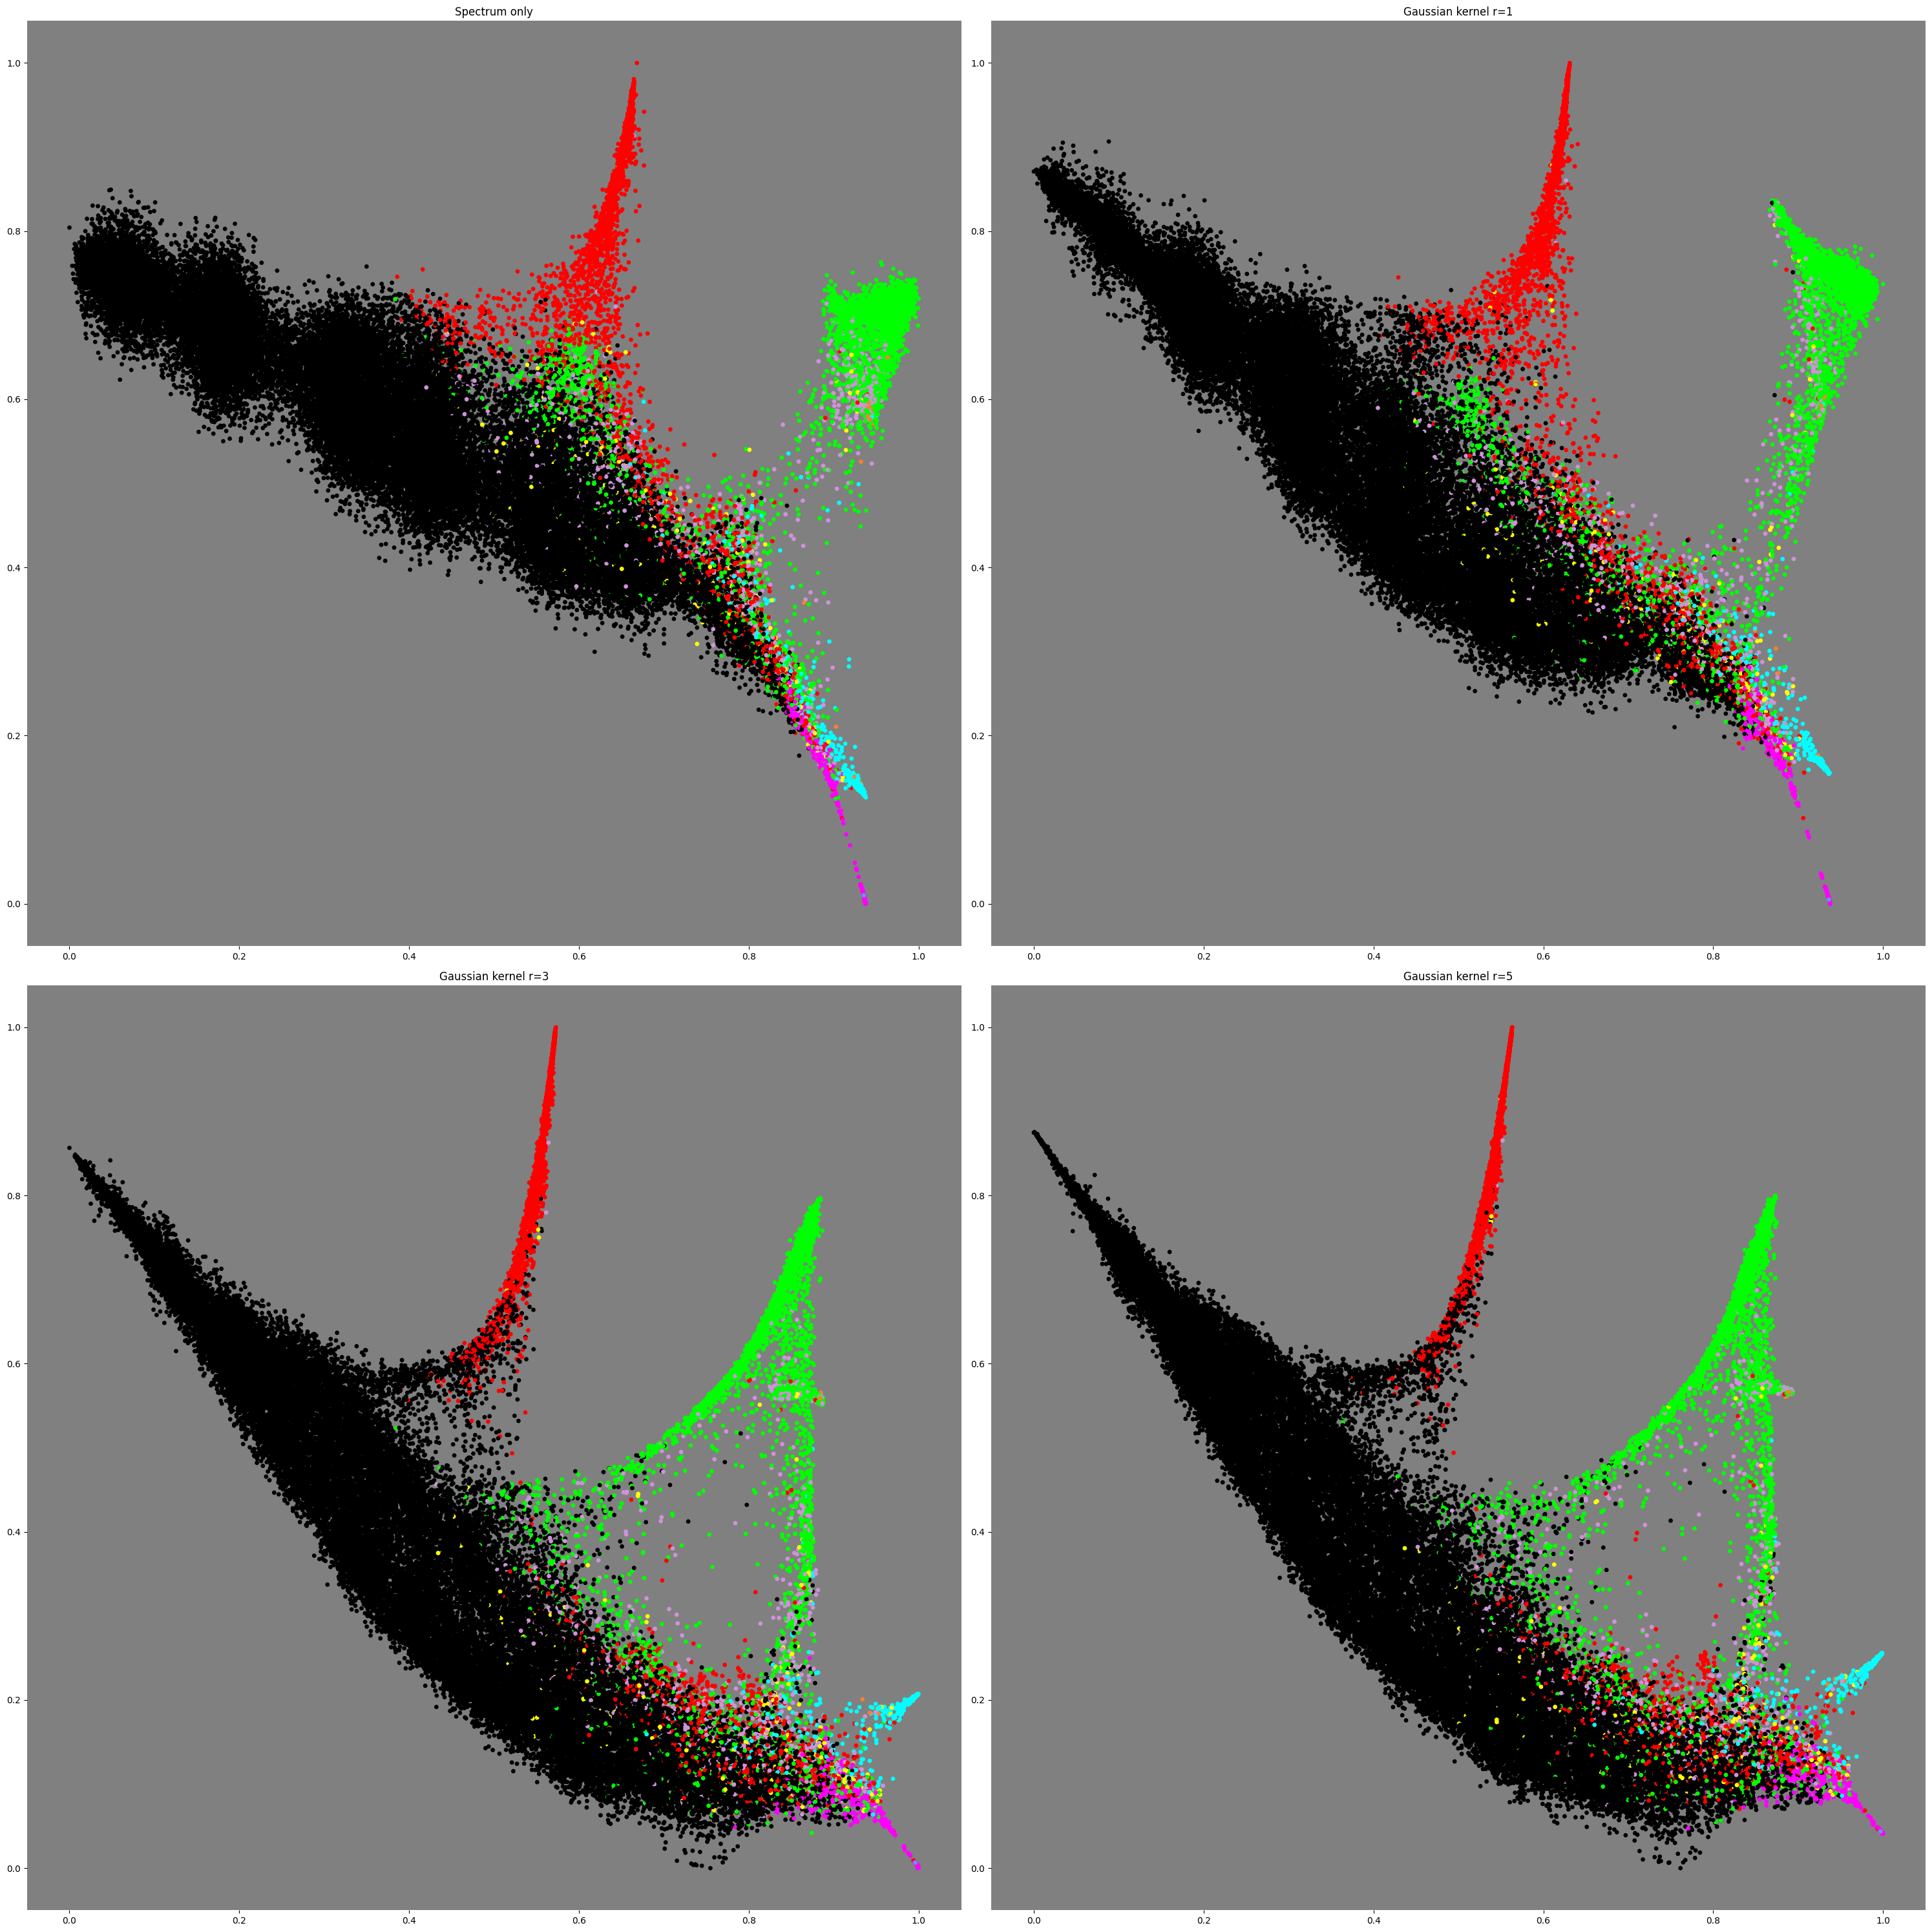

In [69]:
f, ax = plt.subplots(2,2,figsize=(30,30))
sns.despine(left=True, bottom=True, right=True)
names = ['Spectrum only','Gaussian kernel r=1','Gaussian kernel r=3','Gaussian kernel r=5']

num_rows, num_cols = ax.shape

for idx,aslice in enumerate(slices):
    # PaCMAP
    start = datetime.now()
    reduction_model = pacmap.PaCMAP(n_components=2, n_neighbors=None,save_tree = True)
    
    # set the effective spectrum for embedding
    spectrum_2D_eff = spectrum_2D[sample,aslice]
    
    # train model
    reduction_model.fit(spectrum_2D_eff)
    embeddings = reduction_model.embedding_
    
    # scaling (scaled both reduced dimensions to 0-1)
    scaler = MinMaxScaler()
    embeddings = scaler.fit_transform(embeddings)

    # elapsed time
    end = datetime.now()
    etime = end-start
    print('Duration for training PaCMAP is: {}'.format(end - start))

    row_idx = idx // num_cols
    col_idx = idx % num_cols
    
    # plot
    ax[row_idx,col_idx].set_facecolor('gray') 
    ax[row_idx,col_idx].scatter(embeddings[:,0],embeddings[:,1], s=15,c=[colors[i] for i in labels.ravel()[sample]]) 
    ax[row_idx,col_idx].set_title(names[idx])
    f.tight_layout()
    
#plt.axis('off')
plt.show()

### Now load the latent dimensions from autoencoder, reduce them from pacmap, and see how they compare in separability

In [32]:
# load
model_dir = '/Users/aj/Desktop/work/PostDoc_UMCG/work/analysis/EDX_Project/SpectralSpatialData/hyperspectral-autoencoders/examples/'
latent_features_mpl = np.load(os.path.join(model_dir,'tile0_mpl_latent.npy')) 
latent_features_cnn = np.load(os.path.join(model_dir,'tile0_cnn_latent.npy'))     
latest_features_list = [latent_features_mpl,latent_features_cnn]
print(latent_features_mpl.shape)
print(latent_features_cnn.shape)

(262144, 10)
(262144, 10)


In [33]:
# PaCMAP

reduction_model = pacmap.PaCMAP(n_components=2, n_neighbors=None,save_tree = True)
embeddings_list = []
for latent_features in latest_features_list:
    start = datetime.now()
    reduction_model.fit(latent_features[:,:])
    embeddings = reduction_model.embedding_
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings_list.append(embeddings)
    end = datetime.now()
    print('Duration for training PaCMAP is: {}'.format(end - start))

Duration for training PaCMAP is: 0:02:02.429939
Duration for training PaCMAP is: 0:01:29.875040


### Display the scatter plot
- possible mixup between colours here. Check later.

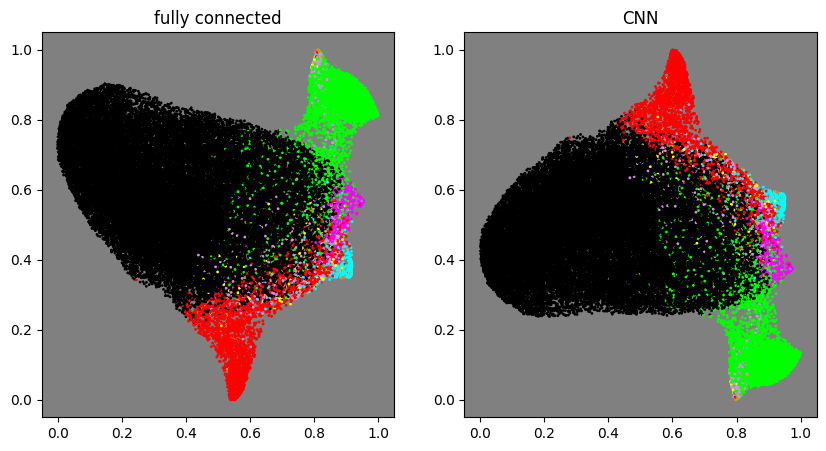

In [34]:
# plot
model_names = ['fully connected','CNN']

f, ax = plt.subplots(1,2,figsize=(10,5))
for idx in range(ax.shape[0]):
    ax[idx].set_facecolor('gray') 
    ax[idx].scatter(embeddings_list[idx][sample,0],embeddings_list[idx][sample,1], s=1,c=[colors[i] for i in labels.ravel()[sample]]) 
    ax[idx].set_title(model_names[idx])
plt.show()

### Show all latent dimension
- Useful to note which of them are empty (or constant). We have 10 here because that's the last layer size within the deephyp network (which is changable). But out of the 10, we have only 5 meaninful latent dimensions in this example. So it's necessary to check (and to avoid using empty dimensions for clustering or other downstream tasks)
- Note: These images resemble also the principal components of the dataset (which were used in preprocessing).

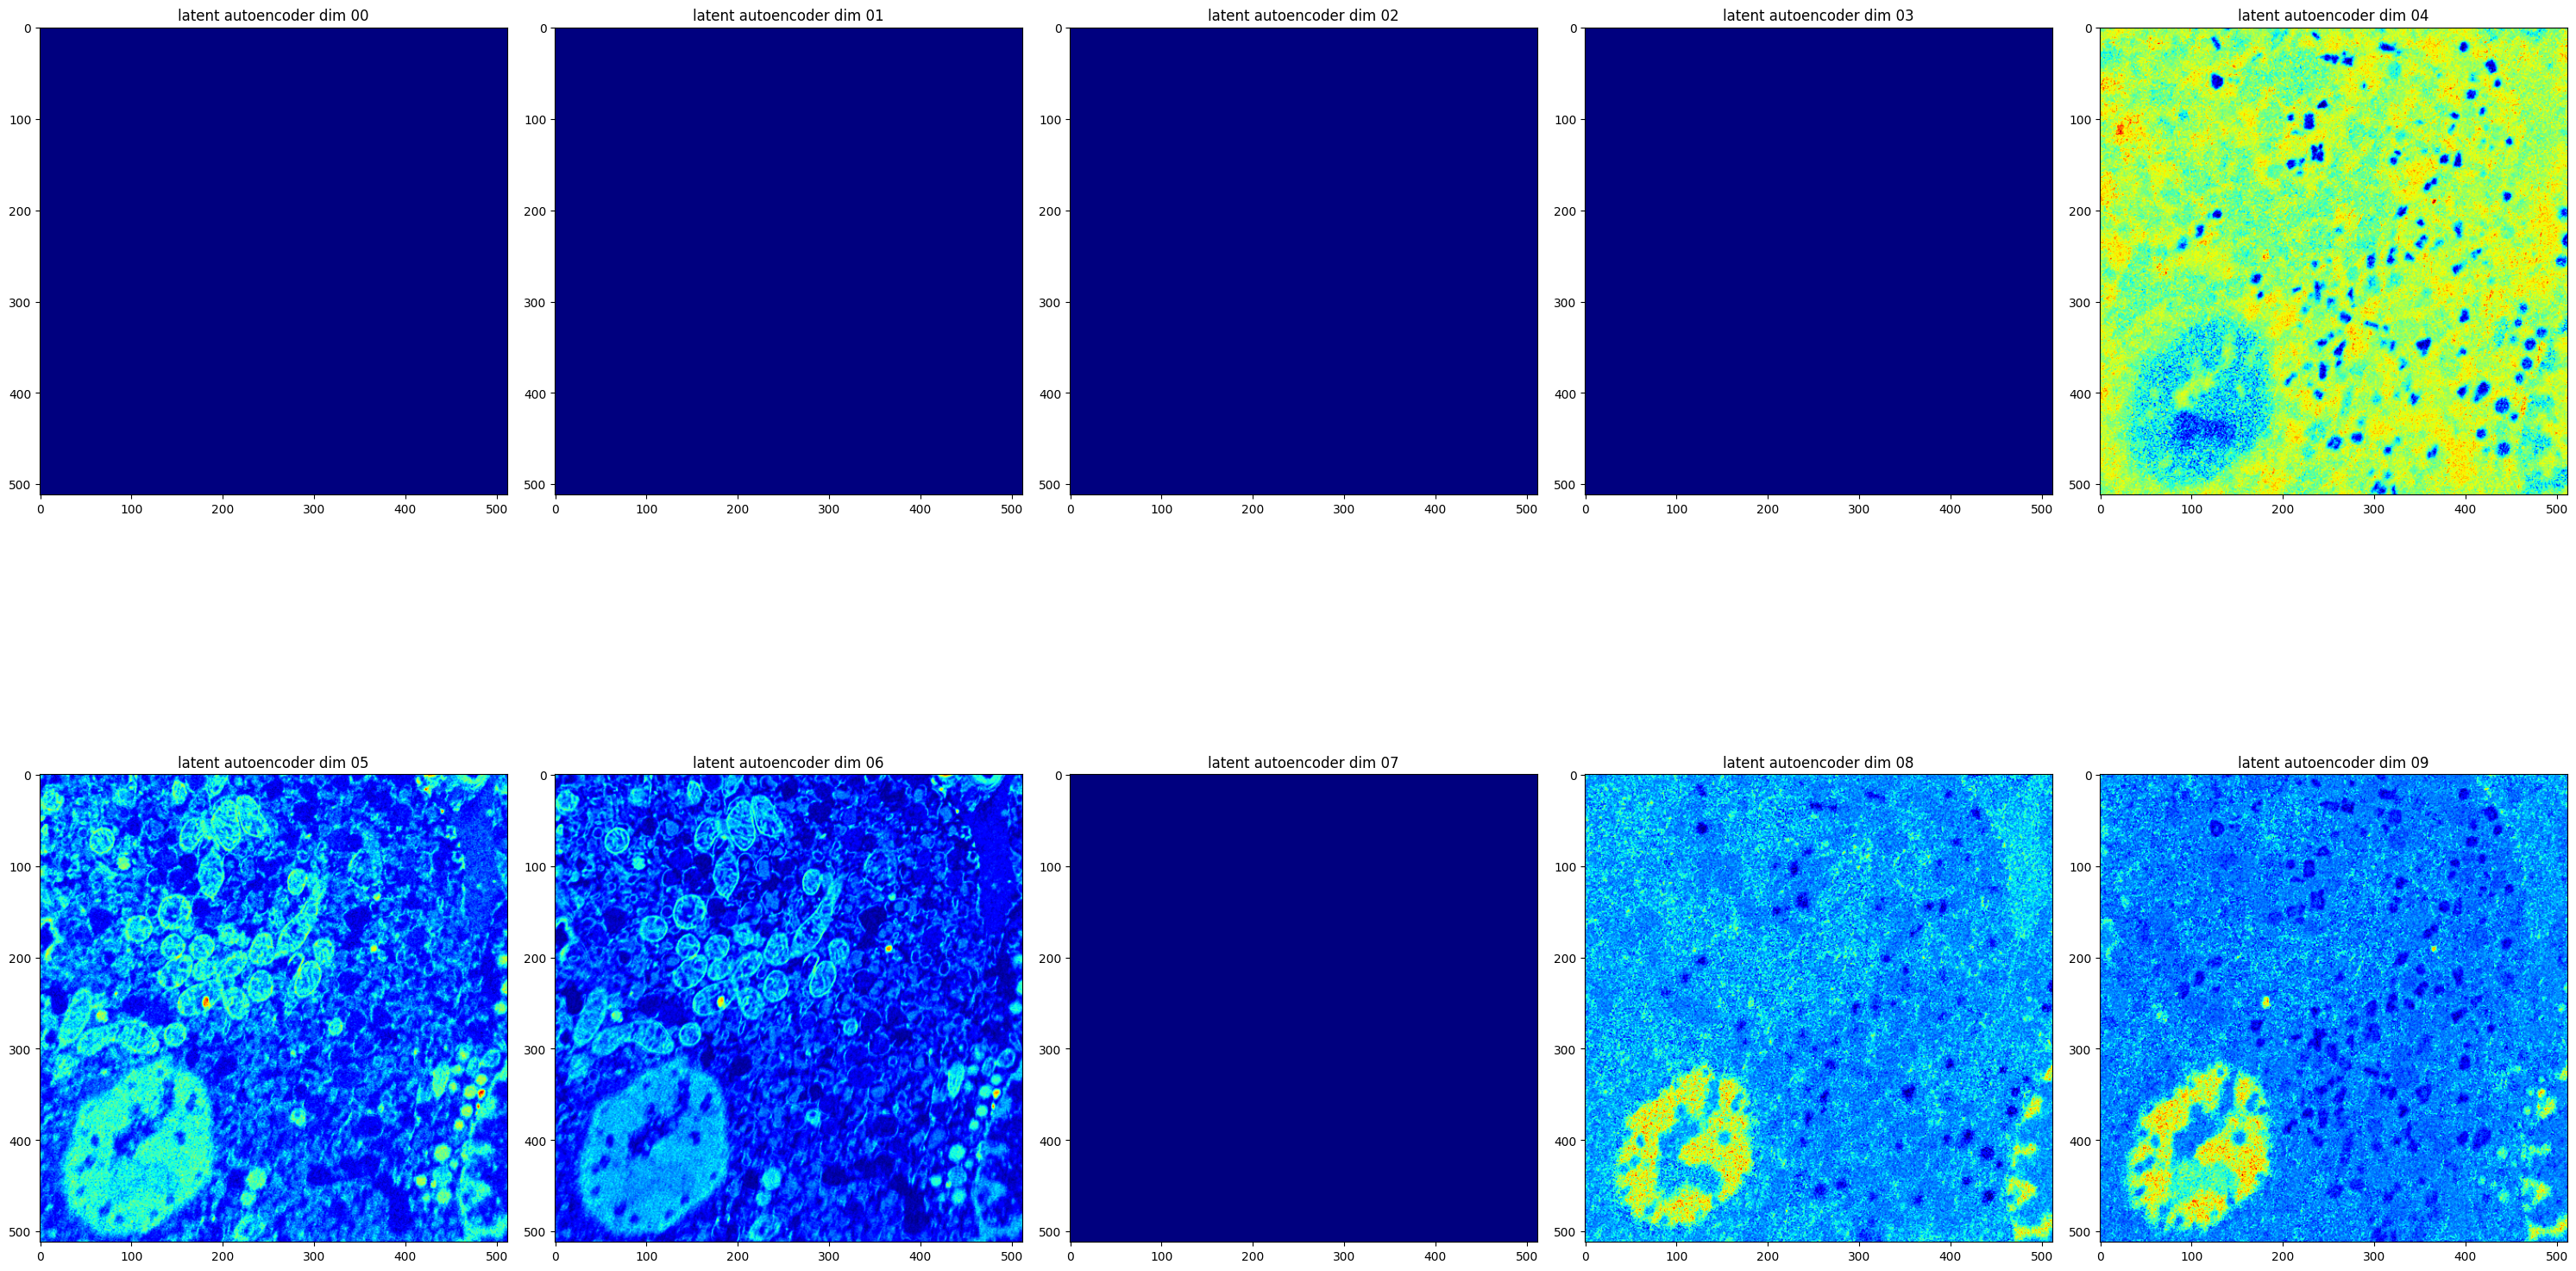

In [42]:
f, ax = plt.subplots(2,5,figsize=(30,20))

num_rows, num_cols = ax.shape
for idx in range(10):
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    ax[row_idx,col_idx].imshow(imgZ[:,:,idx],cmap='jet')
    ax[row_idx,col_idx].set_title('latent autoencoder dim %02d' % idx)
plt.tight_layout()

### Visualize 3 of the latent dimensions as an RGB

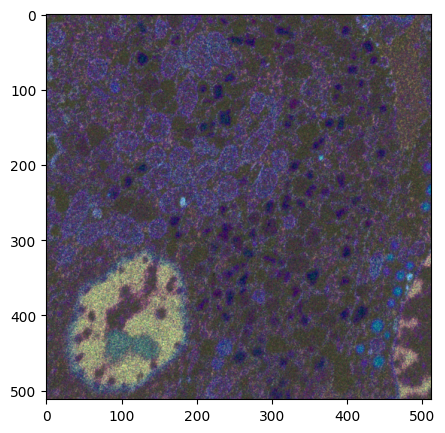

In [51]:
# reshape latent encoding to original image dimensions
imgZ = np.reshape(latent_features_mpl, (512, 512, -1))

colourImg = imgZ.copy()
# this is the selection criteria from deephyp 
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3]]

# or manual selection based on visualization above
#colourImg = colourImg[ :,:,[0,3,8]]
#colourImg = colourImg[ :,:,[0,2,8]]

colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

f, ax = plt.subplots(figsize=(5,5))
ax.imshow(colourImg)

### Apply kmeans to the latet dimensions

/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


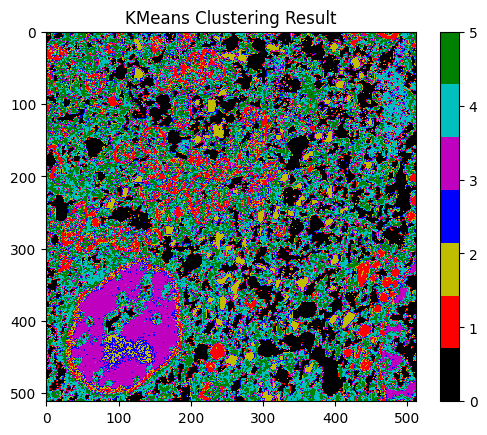

In [63]:
from sklearn.cluster import KMeans
# Apply KMeans clustering 
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(latent_features_mpl[:,:])

# Reshape labels to an image
image_labels = labels.reshape(512, 512)

# Display the output using imshow
plt.imshow(image_labels, cmap=ListedColormap(['k','r','y','b','m','c','g']))  
plt.title('KMeans Clustering Result')
plt.colorbar()
plt.show()

### show the individual cluster maps

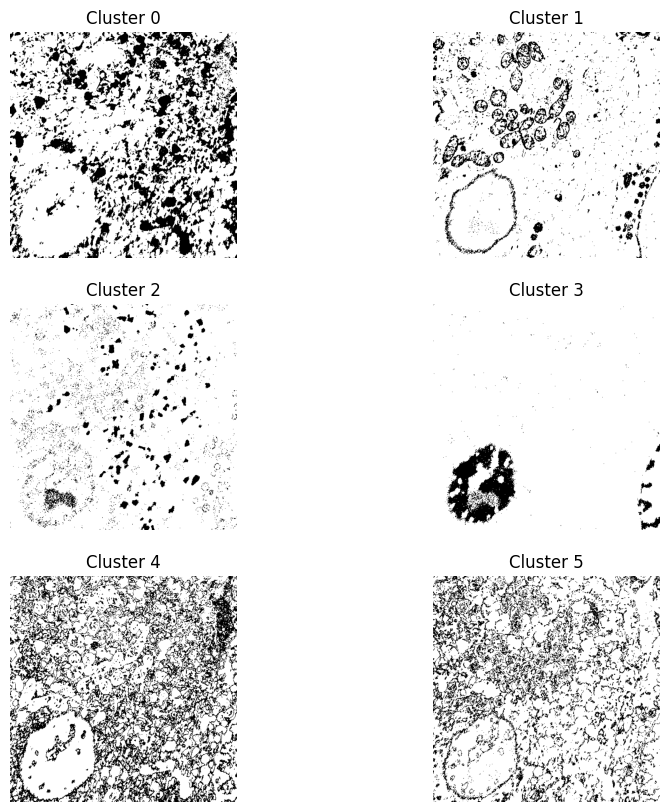

In [64]:
fig, ax = plt.subplots(int(np.ceil(k/2)),2,figsize=(10,10))
num_rows,num_cols = ax.shape
for idx in range(k):
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    binary_image = (image_labels == idx).astype(int)
    ax[row_idx,col_idx].imshow(binary_image, cmap='binary')
    ax[row_idx,col_idx].set_title(f'Cluster {idx}')
    ax[row_idx,col_idx].axis('off')